In [1]:
pylibs = ' '.join(['rasterio','geopandas'])
pylibloc = "/content/drive/MyDrive/pylibs"
#import sys
#import os
#os.symlink('/content/drive/My Drive/Colab Notebooks', pylibloc)
#sys.path.insert(0,pylibloc)
#!pip install --upgrade --target=$pylibloc $pylibs
!pip install $pylibs
#os.symlink('/content/drive/MyDrive/Colab Notebooks/', pylibloc)


     |████████████████████████████████| 19.3 MB 45 kB/s 
     |████████████████████████████████| 994 kB 62.8 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 43.5 MB/s 


In [2]:
%load_ext rpy2.ipython

In [3]:
import numpy
from datetime import datetime
import os
import timeit
import csv
import time
import rasterio
import geopandas

In [4]:
%%R
rlibsloc <- "/content/drive/MyDrive/rlibs"
rlibs <- c("raster","rgdal",'electoral')
#ilibs <- installed.packages(rlibsloc)[,1]
#install.packages(rlibs,lib=rlibsloc)
.libPaths(rlibsloc)
sapply(rlibs,library,character.only=TRUE)

R[write to console]: Loading required package: sp

R[write to console]: Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-27, (SVN revision 1148)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
Path to GDAL shared files: /usr/share/gdal/2.2
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-5



$raster
 [1] "raster"    "sp"        "tools"     "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

$rgdal
 [1] "rgdal"     "raster"    "sp"        "tools"     "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

$electoral
 [1] "electoral" "rgdal"     "raster"    "sp"        "tools"     "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     



In [5]:
# Cores
cores = !cat /proc/cpuinfo | sed -n -e 's/^cpu cores\t: //p'
cores = sum([int(i) for i in cores])
# CPU
cpu = !cat /proc/cpuinfo | grep 'model name'
family = !cat /proc/cpuinfo | grep 'cpu family'
model = !cat /proc/cpuinfo | grep 'model'
stepping = !cat /proc/cpuinfo | grep 'stepping'
machine = ' '.join([entry[0].split(': ')[1] for entry in (cpu,family,model,stepping)])
# bogomips
bogomips = !cat /proc/cpuinfo | grep 'bogomips'
bogomips = bogomips[0].split(': ')[1]
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu = False if len(devices)==1 else [x.physical_device_desc for x in devices if x.device_type == 'GPU'][0].split(', ')[1].split(': ')[1]

In [6]:
%%R
getwd()

[1] "/content"


In [7]:
%%R
# The one with the function
#library(stars)
require(raster)
require(electoral)
#install.packages("rgdal")
#image <- brick('./downsampling2_NDMI_2000-01-01_2020-06-01.tif')[[372]]
#image <- native
bestDownsampling <- function (image, downsampling_factor = 3, positions = FALSE, distribution = NA, breaks = "Sturges"){
  # positions is not exactly implemented now
  # neither is distribution
  # breaks goes to hist, see ?hist for options
  # ... not implemented
  # distribution method
  # 1. Calculate histogram
  histogram_i <- hist(image, maxpixels = ncell(image), plot = FALSE, breaks = breaks)
  
  # 2. Calculate variables depending on the aggregation level (downsampling_factor)
  # patch_size <- downsampling_factor^2 # not used further
  # patch means aggregation areal unit
  patch_nrow <- floor(nrow(image)/downsampling_factor)
  patch_ncol <- floor(ncol(image)/downsampling_factor)
  patch_tcount <- patch_nrow*patch_ncol # areal units after aggregation
  
  # areal units per histogram class. In other words area distribution over histogram classes.
  capture.output(patches_per_class <- seats_lr(1:length(histogram_i$counts),
                                histogram_i$counts,
                                patch_tcount,
                                'quotas-remainders'))
  # the line below appears not used, but it's actually used ~#107
  # rarity_sorted_classes depends on patches_per_class having names
  names(patches_per_class) <- 1:length(patches_per_class)
  
  # 100*histogram_i$counts/ncell(image)
  
  # for each histogram class,
  #   for each areal unit
  #     calculate count native values that would fit in the histogram class
  # the result is a list of downsampled rasters with counts of each histogram class as values
  # this can be called spatially aggregated histogram class distribution, e.g.
  # sahcd <- aggregate((image>histogram_i$breaks[2]&image<=histogram_i$breaks[2+1]),downsampling_factor,sum, expand=FALSE)
  # plot(sahcd)
  # Note: data may be cropped at this level, see expand = false
  
  power_per_class <- lapply(1:length(histogram_i$mids),
                            function(i){
                              aggregate(image>histogram_i$breaks[i]&image<=histogram_i$breaks[i+1],
                                        fact = downsampling_factor,
                                        fun = sum,
                                        expand = FALSE)
                            })
  
  # for each spatially aggregated histogram class distribution
  #   calculate histogram class density at spatially aggregated level
  #     hcd <- table(sahcd[])
  #   associate a descending rank for each count of current class,
  #   i.e. 0 count of current class = high number and
  #   max count of current class = low number
  #   in other words, top ranking is 1, which means that there is a high count
  #   of values of the current class in that areal unit (patch)
  #   the spatially aggregated histogram class distribution is reclassified,
  #   according to the new ranking
  #   some metadata is also added
  
  # t(rbind(hcd,
  # dim(hcd),
  # as.numeric(names(hcd))))
  # ranking <- as.data.frame(cbind(count = hcd,
  #       rank  = dim(hcd):1,
  #       power = as.numeric(names(hcd))))
  # ranking <- ranking[order(ranking$rank),]
  # ranking$count_cumsum <- cumsum(ranking$count)
  # rcl <- ranking[,c("power","rank")]
  # reclassified <- reclassify(sahcd,rcl)
  # plot(reclassified)
  # plot(rankings[[2]]$raster)
  rankings <- lapply(power_per_class,
                     function(ppc){
                       count <- table(ppc[])
                       ranking <- as.data.frame(cbind(
                         count,
                         rank=dim(count):1,
                         power=as.numeric(names(count))))
                       ranking <- ranking[order(ranking$rank),]
                       ranking$count_cumsum <- cumsum(ranking$count)
                       rcl <- ranking[,c("power","rank")]
                       reclassified <- reclassify(ppc,rcl)
                       c(raster=reclassified,meta=list(ranking))
                     })
  rankings <- Map(c,rankings,max_patches=patches_per_class)
  
  ## some tests about the top ranking class
  # plot(stack(rankings[[9]]$raster,power_per_class[[9]]))
  # top_class <- which.min(stack(rankings))
  # plot(top_class)
  # plot(image)
  # 100*table(top_class[])/patch_tcount
  # t(rankings[[1]])[,c("power","rank")]
  # rankings
  # as.numeric(names(ranks[[1]]))
  # rbind(ranks[[1]],dim(ranks[[1]]):1)
  
  # it really feels like the below is equivalent to just ranks <- power_per_class
  # it's because it is. Just checked and ranks is never used again
  # ranks <- lapply(power_per_class,
  #                 function(ppc){
  #                   ppc
  #                 })
  # plot(power_per_class[[1]])
  # plot(power_per_class[[1]][power_per_class[[1]]==9])
  
  # create template empty downsampled raster to be filled
  filled <- rankings[[1]]$raster
  filled[] <- NA
  # plot(filled)
  
  rarity_sorted_classes <- names(sort(patches_per_class))
  #  test_class <- rarity_sorted_classes[4]
  #  test_class_numeric <- as.numeric(test_class)
  # # for each histogram class, sorted by rarity areal units per histogram class (patches_per_class),
  # #   Find positions to fill with the current class, if any are needed
  # #   create template for the current histogram class ranking
  # #   by emptying pixels that are confirmed to not be filled in a previous iteration
  # #   so initially no pixels, hence the need of the empty filled template above
  #      rankings[[test_class_numeric]]$filled <- rankings[[test_class_numeric]]$raster
  #      plot(rankings[[test_class_numeric]]$filled)
  #      rankings[[test_class_numeric]]$filled[!is.na(filled)] <- NA
  # #   count frequency of each ranking
  #      count <- table(rankings[[test_class_numeric]]$filled[])
  # #   create an auxiliary data frame with
  # #     the above count of each ranking
  # #     a cumulative sum
  # #     the rank
  #     current_meta <- as.data.frame(cbind(
  #       count,
  #       cumsum = cumsum(count),
  #       rank = as.numeric(names(count))))
  # #   Rule 1. select as many ranks as they fit before the maximum number of areal units are necessary for the current class
  #      first_ranks <- current_meta$rank[current_meta$cumsum<=rankings[[test_class_numeric]]$max_patches]
  # #   find the position to be filled by these top ranks, and fill them
  #      first_positions <- rankings[[test_class_numeric]]$filled[] %in% first_ranks
  #      filled[first_positions] <- test_class_numeric
  # #   Rule 2. See the end
  # #     Calculate how many positions are left to be filled by the current histogram class
  #        left <- rankings[[test_class_numeric]]$max_patches - current_meta$cumsum[current_meta$rank==first_ranks[length(first_ranks)]]
  # #     Calculate the edge rank, (expand what this is)
  #        edge_rank <- min(current_meta$rank[-which(current_meta$rank %in% first_ranks)])
  # #     Calculate edge positions, 
  #        edge_positions <- which((rankings[[test_class_numeric]]$filled==edge_rank)[])
  # #     Calculate next classes in rarity order and make a raster stack of the rankings
  #        next_classes <- rarity_sorted_classes[which(rarity_sorted_classes==test_class):length(rarity_sorted_classes)][-1]
  #        next_classes_rankings_rasters <- stack(lapply(rankings[as.numeric(next_classes)],'[[',"raster"))
  # #     Extract the rankings for all future classes for the edge ranking positions
  #        extracts <- extract(next_classes_rankings_rasters,edge_positions)
  # #     Find the highest ranking (minimum rank number) for each edge_position
  #        mins <- apply(as.data.frame(extracts),1,FUN=min)
  # #     Glue edge positions with the minimum rank number (highest rank)
  # #       Note: but I don't remember to which class this minimum ranking belongs to
  # #         it seems that all I know is that it's of one of the next classes
  # #       Answer Note: it doesn't matter, because I will fill the current class anyway
  # #         I just need to know which positions have the lowest ranking in their respective class, whichever it is
  # #       second_positions <- rbind(edge_positions,mins)
  # #     Order the positions ascending by their ranking
  # #       ordered_second_positions <- second_positions["edge_positions", order(second_positions["mins",])]
  # #     The point of all of the above is to find which positions to still fill with the current class,
  # #       if positions are still needed, i.e. left > 0.
  # #     The overall idea is to fill the positions with the lowest rank (highest rank number)
  # #       which means that I'm filling the positions with the least count of their respective class
  # #       pretty smart :D
  # #       fill_second_positions <- tail(ordered_second_positions,left)
  # #       Note: what's not smart though is to not implement the only if left>0 do rule 2
  # #     Actually fill the necessary left positions with the current class number
  #        filled[fill_second_positions] <- test_class_numeric
  # # loop end
  # 
  # fill whatever is not filled with the most popular class. This makes sense, because one more loop would have achieved the same, but with extra computation
  # The last loop will not have any next classes to look for, so that's why it's simplified.
  # filled[is.na(filled)] <- as.numeric(rarity_sorted_classes[length(rarity_sorted_classes)])
  for (cls in rarity_sorted_classes[1:(length(rarity_sorted_classes)-1)]) {
    cls_number <- as.numeric(cls)
    if (rankings[[cls_number]]$max_patches > 0) {
      rankings[[cls_number]]$filled <- rankings[[cls_number]]$raster
      rankings[[cls_number]]$filled[!is.na(filled)] <- NA
      count <- table(rankings[[cls_number]]$filled[])
      current_meta <- as.data.frame(cbind(
        count,
        cumsum = cumsum(count),
        rank = as.numeric(names(count))))
      
      #first rule eligible ranks
      first_ranks <- current_meta$rank[current_meta$cumsum<=rankings[[cls_number]]$max_patches]
      first_positions <- rankings[[cls_number]]$filled[] %in% first_ranks

      filled[first_positions] <- cls_number
      
      #second rule eligible ranks
      filled_count <- current_meta$cumsum[current_meta$rank==first_ranks[length(first_ranks)]]
      # The if below is necessary for the situation when the first rank is also an edge rank
      # it is necessary because you need to know the last used rank to calculate the edge_rank
      if(length(first_ranks)==0){
        filled_count <- 0
        edge_rank <- 1
      }else{
        edge_rank <- min(current_meta$rank[-which(current_meta$rank %in% first_ranks)])
      }
      left <- rankings[[cls_number]]$max_patches - filled_count
      if (length(left) == 1) {
        edge_positions <- which((rankings[[cls_number]]$filled==edge_rank)[])
        
        next_classes <- rarity_sorted_classes[which(rarity_sorted_classes==cls):length(rarity_sorted_classes)][-1]
        next_classes_rankings_rasters <- stack(lapply(rankings[as.numeric(next_classes)],'[[',"raster"))
        extracts <- raster::extract(next_classes_rankings_rasters,edge_positions)
        mins <- apply(as.data.frame(extracts),1,FUN=min)
        second_positions <- rbind(edge_positions,mins)
    
        ordered_second_positions <- second_positions["edge_positions",order(second_positions["mins",])]
        
        fill_second_positions <- tail(ordered_second_positions,left)
        
        filled[fill_second_positions] <- cls_number
      }
    }
  }
  #writeRaster(filled,"g:/My Drive/Paper1-ml/pre_filled.tif")
  filled[is.na(filled)] <- as.numeric(rarity_sorted_classes[length(rarity_sorted_classes)])

  # upsample the class filled raster
  large_filled <- disaggregate(filled,downsampling_factor)
  #writeRaster(large_filled,"g:/My Drive/Paper1-ml/large_filled.tif")
  # crop the original image so that it fits the downsampling factor
  cropped_image <- crop(image,large_filled)
  # classify the native resolution image according to histogram classes
  ranked_image <- cut(cropped_image, histogram_i$breaks)

  # filter out all the pixels that are known to not be selected because they are in the wrong class for the areal unit
  filtered_image <- cropped_image
  filtered_image[large_filled!=ranked_image] <- NA
  
  # function that chooses the closest to average between some values
  # I'm using it for aggregation among possible values for each areal unit
  closest_to_average <- function(x,na.rm){
    if(!all(is.na(x))){
      average <- mean(x,na.rm=na.rm)
      result <- x[which.min(abs(x-average))]
      if (is.na(result)) print('is na')
    }
    else{
      result <- NA #TODO this should be NA, which is fine
    }
    return(result)
  }
  final_image <- aggregate(filtered_image,downsampling_factor,closest_to_average, expand = FALSE)

  # Now make sure there's no NAs
  selectCentral <- function(x,na.rm){
    count <- length(x)
    # roundup (count - side * even)/2
    return(x[ceiling((count-sqrt(count)*((1+count)%%2))/2)])
  }
  
  final_image <- disaggregate(final_image,downsampling_factor)
  final_image[is.na(final_image)] <- cropped_image[is.na(final_image)]
  
  final_image <- aggregate(final_image, downsampling_factor, selectCentral, expand = FALSE)
  return(final_image)
}
#test <- bestDownsampling(image)
#identical(test,final_image)
#plot(test)


get_novel_positions <- function(reference,dfactor){
  # Calculates the positions that would be sampled from a raster reference, at downsampling factor dfactor
  reference_downsampled <- bestDownsampling(reference,dfactor)
  #plot(reference_downsampled,main = paste('novel downsampled'))
  reference_upsampled <- disaggregate(reference_downsampled, dfactor)
  positions <- reference_upsampled == crop(reference, reference_upsampled)
  return(positions)
}
get_novel_positions_stack <- function(rasterStack,dfactor){
  # Calculates the positions that should be sampled
  # from a RasterStack (e.g. timeseries), at downsampling factor dfactor.
  # The positions are first calculated for each frame,
  # and then the most selected positions are returned
  positions <- brick(sapply(unstack(rasterStack), get_novel_positions, dfactor))
  sumpositions <- sum(positions)
  highpositions <- aggregate(sumpositions, dfactor, max, expand = FALSE)
  highpositions <- disaggregate(highpositions, dfactor)
  positions <- highpositions == sumpositions
  #plot(positions,main='positions')
  return(positions)
}
selectFirst <- function(x,na.rm){
  #x[Position(function(x)!is.na(x),x)]
  #na.omit(x)[1]
  x[!is.na(x)][1]
}
novelStackDownsample <- function(rasterStack, dfactor = dfactor ){
  positions <- get_novel_positions_stack(rasterStack, dfactor = dfactor)
  #writeRaster(positions,'/content/drive/MyDrive/Paper1-ml/positions.tif')
  #writeRaster(rasterStack,'/content/drive/MyDrive/Paper1-ml/rasterStack.tif')
  rasterStack <- crop(rasterStack,positions)
  rasterStack[!positions] <- NA
  result <- aggregate(rasterStack,dfactor,fun=selectFirst, expand = FALSE)
  #writeRaster(result,'/content/drive/MyDrive/Paper1-ml/result.tif')
  #plot(result,main='downsampled stack')
  return(result)
}
# function that selects 1 random pixel
selectRandom <- function(x,na.rm){
  sample(x,1)
}
readDownsampleWrite <- function(ifile,downMethod,factor,ofile){
  rasterStack <- stack(ifile)
  result <- if (downMethod == 'novel') novelStackDownsample(rasterStack,factor) else aggregate(rasterStack,factor,selectRandom, expand=FALSE)
  names(result) <- names(rasterStack)
  writeRaster(result, ofile, datatype='INT2U', overwrite = TRUE)
}

In [8]:
def downsampling_reader(ifile, factor, downMethod):
  from rasterio.enums import Resampling
  icsv = os.path.splitext(ifile)[0]+'.shp'
  training = geopandas.read_file(icsv)
  training[training.columns[0:7]] = training[training.columns[0:7]].astype(numpy.int16)
  if downMethod in ('novel','random'):
    ofile = os.path.splitext(ifile)[0] + '-'+ downMethod + str(factor) + os.path.splitext(ifile)[1]
    %Rpush ifile factor downMethod ofile
    %R readDownsampleWrite(ifile, downMethod, factor, ofile)
    ifile = ofile
    downscale_factor = 1
    downMethod = 'nearest'
  else:
    downscale_factor = factor
  with rasterio.open(ifile) as dataset:
    # resample data to target shape
    ndDataset = dataset.read(
      out_shape=(
        dataset.count,
        int(dataset.height / downscale_factor),
        int(dataset.width / downscale_factor)
      ),
      resampling=Resampling[downMethod]
    )
    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
      (dataset.width // ndDataset.shape[-1]),
      (dataset.height // ndDataset.shape[-2])
    )
    return (ndDataset,training,dataset.crs,transform)

def rf_wrapper(ndDataset, training):
  '''calculates results with fixed parameters'''

  toPredict = ndDataset.reshape(7,ndDataset.shape[1]*ndDataset.shape[2]).transpose()

  features = training.filter(like='SR')
  labels = training.filter(like='discrete')

  #Import Random Forest Model
  from sklearn.ensemble import RandomForestClassifier

  #Create a Gaussian Classifier
  clf = RandomForestClassifier(n_estimators = 100, random_state = 42).fit(features,labels.values.ravel())
  classified = clf.predict(toPredict).transpose().reshape(ndDataset.shape[1],ndDataset.shape[2])
  return classified

def result_writer(classified,ifile,factor,downMethod,algorithm,crs,transform,experiment):
  #print("done calculating. Now exporting and stuff..")
  dirName = os.path.dirname(ifile)
  basename = os.path.basename(ifile)
  niceId = basename.split('-')[0]
  exportName = '.'.join(('-'.join((niceId,algorithm,downMethod,str(factor),experiment)),'tif'))
  exportName = os.path.join(dirName,exportName)

  classified_dataset = rasterio.open(
    exportName,
    'w',
    driver='GTiff',
    height=classified.shape[0],
    width=classified.shape[1],
    count=1,
    dtype=classified.dtype,
    crs=crs,
    transform=transform
    )
  classified_dataset.write(classified,1)
  #print("done even exporting. Donno whatchu waitin fo")
  return classified_dataset.close()

In [9]:
# By default timeit eats the return of the call, the monkey-patch below fixes it
timeit.template="""
def inner(_it, _timer{init}):
  {setup}
  _t0 = _timer()
  for _i in _it:
    retval = {stmt}
  _t1 = _timer()
  return _t1 - _t0, retval"""

In [10]:
#ifile = '/content/drive/MyDrive/Paper1-ml/woodside-CLBS-1000-4526_5-2250_5-EPSG32612-2019-07-01-2019-10-01-classYear2019-maxCloud1.tif'
#ifile = '/content/drive/MyDrive/Paper1-ml/eppendorf-CLBS-1000-3331_5-1876_5-EPSG32633-2019-07-01-2019-10-01-classYear2019-maxCloud1.tif'
#ifile = '/content/drive/MyDrive/Paper1-ml/galati-CLBS-1000-1004_5-5722_5-EPSG32635-2019-07-01-2019-10-01-classYear2019-maxCloud1.tif'
#ifile = '/content/drive/MyDrive/Paper1-ml/kaz-CLBS-1000-719_5-3487_5-EPSG32645-2019-07-01-2019-10-01-classYear2019-maxCloud1.tif'
#ifile = '/content/drive/MyDrive/Paper1-ml/maram-CLBS-1000-1500_5-3250_5-EPSG32638-2019-07-01-2019-10-01-classYear2019-maxCloud1.tif'
#ifile = '/content/drive/MyDrive/Paper1-ml/victoria-CLBS-1000-2660_5-1363_5-EPSG32621-2019-01-01-2019-04-01-classYear2019-maxCloud1.tif'
#ifile = '/content/drive/MyDrive/Paper1-ml/aguada-CLBS-1000-1389_5-3818_5-EPSG32619-2019-01-01-2019-04-01-classYear2019-maxCloud1.tif'
#ifile = '/content/drive/MyDrive/Paper1-ml/aasvoelness-CLBS-1000-3205_5-1111_5-EPSG32634-2019-01-01-2019-04-01-classYear2019-maxCloud1.tif'
#ifile = '/content/drive/MyDrive/Paper1-ml/grasspatch-CLBS-1000-578_5-3718_5-EPSG32651-2019-01-01-2019-04-01-classYear2019-maxCloud1.tif'
#ifile = '/content/drive/MyDrive/Paper1-ml/wanaka-CLBS-1000-1908_5-3830_5-EPSG32659-2019-01-01-2019-04-01-classYear2019-maxCloud1.tif'

In [11]:
#whenever you change the header of the csv, also change the version
version = 5
repeat = 1
experiment = 'restart3'
#downMethod = "average"
algorithm = 'random_forest'
for downMethod in ("novel","nearest","random","average"):
#for downMethod in ('novel',):
  print(downMethod)
  #t=timeit.Timer(stmt='bfastmonitor_wrapper(ifile,factor,method,gpu,experiment)', globals=globals())
  downRead_timer=timeit.Timer(stmt='downsampling_reader(ifile,factor,downMethod)', globals=globals())
  algorithm_timer = timeit.Timer(stmt='rf_wrapper(nd, training)',globals=globals())
  writer_timer = timeit.Timer(stmt='result_writer(classified,ifile,factor,downMethod,algorithm,crs,transform,experiment)',globals=globals())
  ofilepath = os.path.join(os.path.dirname(ifile),'runtimes-' + algorithm + '-' + str(version) + '.csv')
  if os.path.isfile(ofilepath):
    ofile = open(ofilepath,'a')
    writer = csv.writer(ofile)
  else:
    ofile = open(ofilepath,'w')
    writer = csv.writer(ofile)
    writer.writerow(["timestamp","experiment","ifile","algorithm","method","factor","machine","cores","bogomips","gpu","repeat","downReadTime","bfastmonitorTime","writeTime"])
  myGlobals=globals()
  #for factor in range(10,0,-1):
  for factor in range(1,11,1):
  #for factor in range(3,4,1):
    print(factor)
    row = [time.time(),
          experiment,
          ifile,
          algorithm,
          downMethod,
          factor,
          machine,
          cores,
          bogomips,
          gpu,
          repeat]
    downTimer,(nd,training,crs,transform) = downRead_timer.repeat(repeat=1,number=1)[0]
    algorithmTimer = algorithm_timer.repeat(repeat=repeat, number=1)
    classified = algorithmTimer[0][1]
    algorithmTimer = min([entry[0] for entry in algorithmTimer])
    writerTimer = writer_timer.repeat(repeat=1, number=1)
    writerTimer = min([entry[0] for entry in writerTimer])
    row.extend([downTimer,algorithmTimer,writerTimer])
    writer.writerow(row)
  ofile.close()

novel
1
2
3
4
5
6
7
8
9
10
nearest
1
2
3
4
5
6
7
8
9
10
random
1
2
3
4
5
6
7
8
9
10
average
1
2
3
4
5
6
7
8
9
10


In [ ]:
nd,training,crs,transform = downsampling_reader(ifile,10,'novel')


[1] "Seats allocated"
class      : RasterLayer 
dimensions : 1000, 1000, 1e+06  (nrow, ncol, ncell)
resolution : 30, 30  (x, y)
extent     : 518280, 548280, 4334400, 4364400  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=12 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : memory
names      : layer 
values     : 1, 16  (min, max)

class      : RasterLayer 
dimensions : 1000, 1000, 1e+06  (nrow, ncol, ncell)
resolution : 30, 30  (x, y)
extent     : 518280, 548280, 4334400, 4364400  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=12 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : memory
names      : layer 
values     : 1, 23  (min, max)

[1] "Seats allocated"
class      : RasterLayer 
dimensions : 1000, 1000, 1e+06  (nrow, ncol, ncell)
resolution : 30, 30  (x, y)
extent     : 518280, 548280, 4334400, 4364400  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=12 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
so

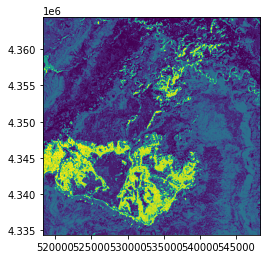

In [ ]:
from rasterio.plot import show
test = rf_wrapper(nd,training)
show(test, transform = transform)

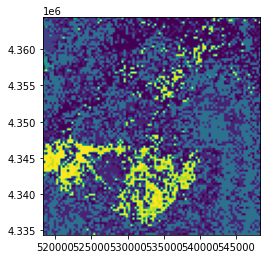

In [ ]:
from rasterio.plot import show
test = rf_wrapper(nd,training)
show(test, transform = transform)

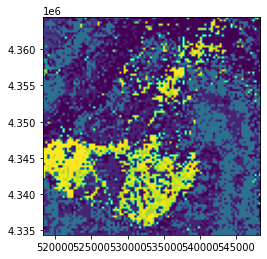

In [ ]:
from rasterio.plot import show
test = rf_wrapper(nd,training)
show(test, transform = transform)

In [ ]:
tuple(test4.slotnames())

('file',
 'data',
 'legend',
 'title',
 'extent',
 'rotated',
 'rotation',
 'ncols',
 'nrows',
 'crs',
 'history',
 'z')

In [ ]:
test4.slots['data'].slots['values']

ReferenceError: ignored

TypeError: ignored

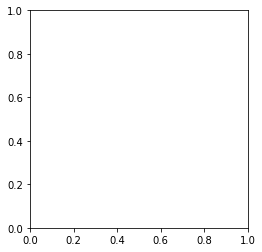

In [ ]:
from rasterio.plot import show
show(test4)